In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   

In [2]:
! mkdir -p r_packages
! echo 'install.packages("jpeg", repos="http://cran.r-project.org", lib="r_packages")' | /usr/bin/R --slave

trying URL 'http://cran.r-project.org/src/contrib/jpeg_0.1-9.tar.gz'
Content type 'application/x-gzip' length 18596 bytes (18 KB)
downloaded 18 KB

* installing *source* package 'jpeg' ...
** package 'jpeg' successfully unpacked and MD5 sums checked
** using staged installation
** libs
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c read.c -o read.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c reg.c -o reg.o
gcc -std=gnu99 -I"/usr/share/R/include" -DNDEBUG     -fpic  -g -O2 -fdebug-prefix-map=/build/r-base-jbaK_j/r-base-3.6.3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -g  -c write.c -o write.o
gcc -

In [128]:
CLBc = CLBXML.CLBConfigWriter( )



CLBc.addGeomParam('nx', 160)
CLBc.addGeomParam('ny', 120)
CLBc.addGeomParam('nz', 2)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWPressure()
CLBc.addBox(nx=1)

params = {
        "Viscosity":1/6.,
        "ForceX":0.05,
        "Magic": 3/16.,
        "LinearReactionRate": 0.01,
        "Diffusivity_PHI": 1./3.,
        "Init_PHI": 1E-5,
}

CLBc.addModelParams(params)


CLBc.addRunR(eval=\
f"""
    library('jpeg', lib="r_packages")
    
    myurl <- "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/M-18A_Dromader_CALM.jpg/160px-M-18A_Dromader_CALM.jpg"
    z <- tempfile()
    download.file(myurl,z,mode="wb", quiet=TRUE);
    pic <- readJPEG(z);
    file.remove(z) # cleanup
    
    y = Solver$Geometry$X / 160 -0.5
    x = Solver$Geometry$Y / 120 - 0.5
    
    #Solver$Fields$Init_PHI_External[] =  sin(2*pi*(y+0.5))^2;

    Solver$Fields$Permability[] = t(pic[,,1]) + 1E-8;
    #Solver$Fields$Permability[] = 1-exp(-15*(x*x+y*y)) + 1E-8;
    #Solver$Actions$InitFromExternalAction();
    
""")

CLBc.addHDF5()
time = 2000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
#CLBc.addHDF5()

CLBc.write('Pseudo2DReaction.xml')

#f = open('AllenCahnTrapezoidal.xml', 'r')
#XML(''.join(f.readlines()))

! rm -rf ./output/Pseudo2DReaction* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo2DReaction.xml > /dev/null


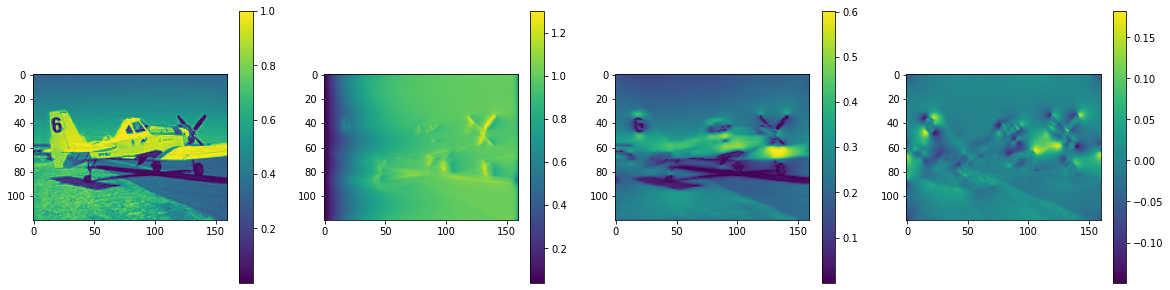

In [129]:
i = time
f = h5py.File('./output/Pseudo2DReaction_HDF5_%08d.h5'%i)    
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(f['Permability'][0,:,:])
plt.colorbar()
plt.subplot(142)
plt.imshow(f['PHI'][0,:,:])
plt.colorbar()
plt.subplot(143)
plt.imshow(f['U'][0,:,:,0])
plt.colorbar()
plt.subplot(144)
plt.imshow(f['U'][0,:,:,1])
plt.colorbar()


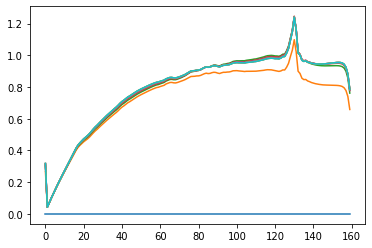

In [130]:
i = 0
for i in range(0,time,int(time/10)):
    f = h5py.File('./output/Pseudo2DReaction_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,50,:])



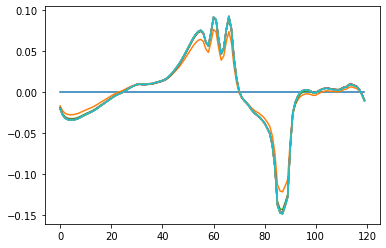

In [131]:
i = 0
for i in range(0,time,int(time/10)):
    f = h5py.File('./output/Pseudo2DReaction_HDF5_%08d.h5'%i)    
    plt.plot(f['PHI'][0,:,0] - np.average(f['PHI'][0,:,0]))



In [132]:
shape = f['U'][0,:,:,1].shape

X,Y = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))

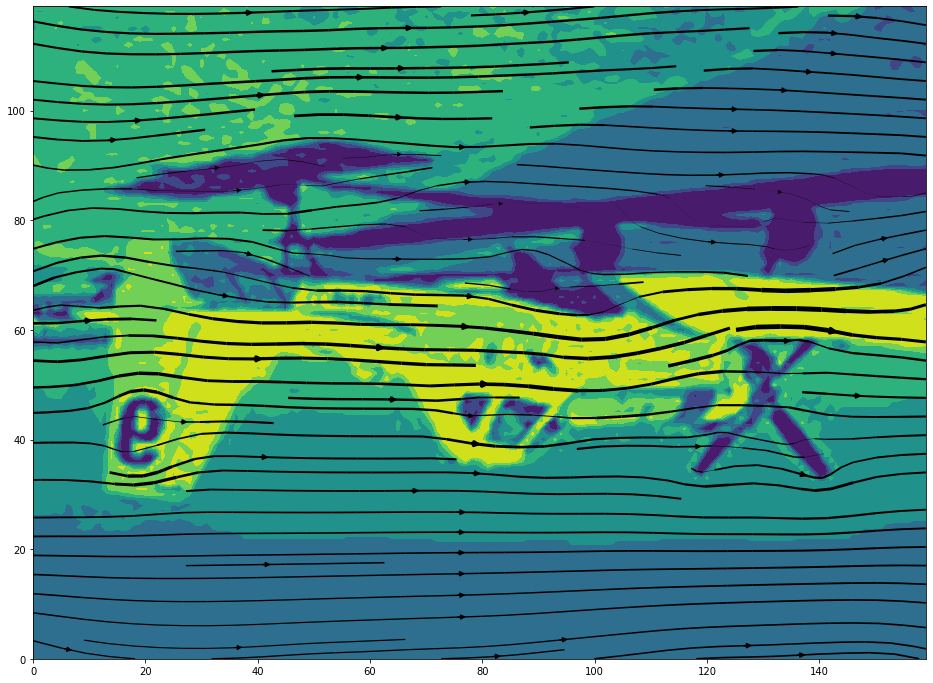

In [133]:
plt.figure(figsize=(16,12))
plt.contourf(X,Y,f['Permability'][0,:,:])

speed = np.sqrt( f['U'][0,:,:,0]**2  + f['U'][0,:,:,1]**2 )
lw = 5*speed / speed.max()


plt.streamplot(X,Y,f['U'][0,::1,:,0],f['U'][0,::1,:,1], density=1.2, color='k', linewidth=lw)

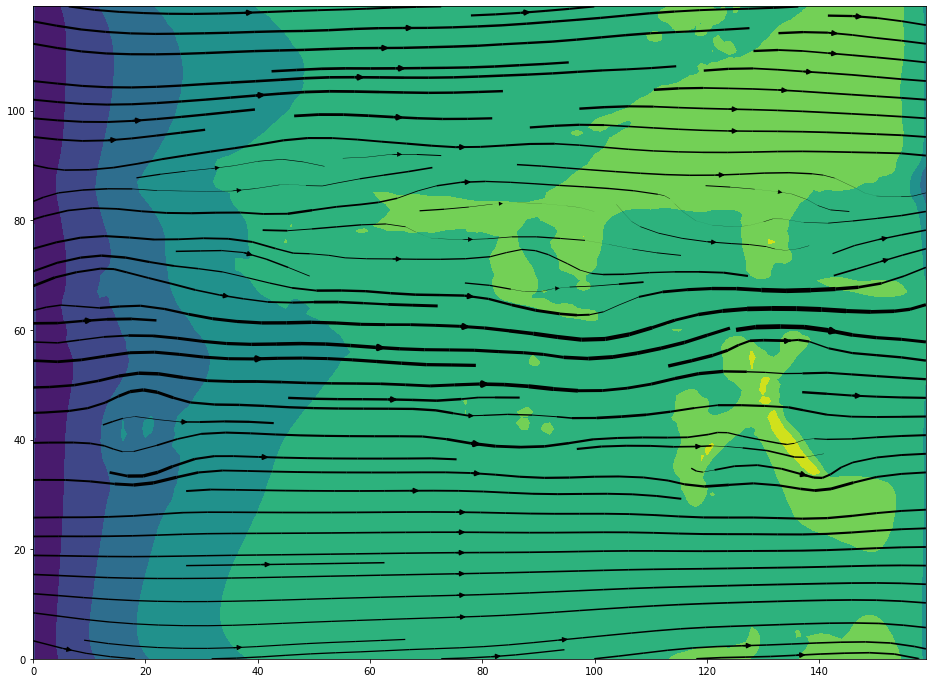

In [134]:
plt.figure(figsize=(16,12))
plt.contourf(X,Y,f['PHI'][0,:,:])

speed = np.sqrt( f['U'][0,:,:,0]**2  + f['U'][0,:,:,1]**2 )
lw = 5*speed / speed.max()


plt.streamplot(X,Y,f['U'][0,::1,:,0],f['U'][0,::1,:,1], density=1.2, color='k', linewidth=lw)